# Coffee Roasting Data Analysis
### by Chet Gray

*A project for Code Louisville's Python for Data May 2018 course*

## Overview

When roasting a batch of coffee, two of the key points at the beginning of the process are the drop (or charge) and the turn-around. The drop/charge is the beginning of the roast, where the (room temperature) beans enter the roasting chamber, and the turn-around is where the measured temperature of the roast environment bottoms out and begins to rise.

Anecdotally, I have observed that how quickly turn-around occurs after drop varies day to day, and I suspect that there is some correlation with ambient temperature. As consistency in the temperature profile of a particular coffee's roast is desirable, finding such correlation would help me anticipate and adjust for that variation.

In [1]:
import csv
import io
import re
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd

/home/chet/.local/share/virtualenvs/roast_data-xYYIALY_/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 56, got 52
  return f(*args, **kwds)


## Roast data

The Loring Merlin coffee roaster logs data at 6-second intervals, and after every batch sends an e-mail to a configured address with the most recent log attached in CSV format. I wrote a utility script, `roast_data_sync.py`, to fetch these attachments and store them as text blobs in a SQLite database, which, while not ideal in the long term, is fine for an initial step for my purposes. The script can be run from the command line, or imported as a module in Python and used via method calls.

As this is only useful for those with access to the e-mail account that receives these logs, I have included a small bit of sample data (all downloaded logs are over 1 GB in size), with [explanation below](#Importing-sample-CSVs).

We only need an extracted subset of the roast log data to do this analysis, so that subset is included later.

#### Fetching e-mailed roast logs

To generate Gmail access credentials, follow **Step 1: Turn on the Gmail API** of the [Gmail API Python Quickstart](https://developers.google.com/gmail/api/quickstart/python). Save the OAuth credentials file to the project working directory as `client_secret.json`.

Run `roast_data_sync.py` to fetch roast logs:

```console
$ ./roast_data_sync.py --help
usage: roast_data_sync.py [-h] [--database DB_PATH] [--secret SECRET_PATH]
                          [--after AFTER_DATE] [--before BEFORE_DATE]
                          [csv_files [csv_files ...]]

Synchronize roast database with latest roast logs.

positional arguments:
  csv_files             **NOT IMPLEMENTED** CSV file(s) to import (default:
                        None)

optional arguments:
  -h, --help            show this help message and exit
  --database DB_PATH    SQLite database file (default: roast_data.sqlite)
  --secret SECRET_PATH  OAuth client ID file (default: client_secret.json)
  --after AFTER_DATE
  --before BEFORE_DATE
$ ./roast_data_sync.py
162b546ec48fd84d 2018-04-11 07:00:22 downloading...
162b532e3e7195d6 2018-04-11 06:38:29 downloading...
162b521401bf1bd1 2018-04-11 06:19:14 downloading...
162b5119cd9b41c8 2018-04-11 06:02:08 downloading...
162b5020013ebd22 2018-04-11 05:45:06 downloading...
[...]
```

#### Importing sample CSVs

In [2]:
with open('sample_message.csv', newline='') as csvfile:
    sample_message = next(csv.reader(csvfile))
with open('sample_message_data.csv', newline='') as csvfile:
    sample_message_data = next(csv.reader(csvfile))
    
con = sqlite3.connect('roast_data.sqlite',
                      detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)
try:
    with con:
        con.execute('''
            CREATE TABLE IF NOT EXISTS message (
                id TEXT PRIMARY KEY,
                snippet TEXT,
                internal_date TIMESTAMP, -- Works with sqlite3.PARSE_DECLTYPES
                attachment_id TEXT)
            ''')
        con.execute('''
            CREATE TABLE IF NOT EXISTS message_data (
                message_id TEXT PRIMARY KEY REFERENCES message(id) ON DELETE CASCADE ON UPDATE CASCADE,
                data TEXT)
            ''')
        con.execute('INSERT INTO message VALUES (?, ?, ?, ?)', sample_message)
        con.execute('INSERT INTO message_data VALUES (?, ?)', sample_message_data)
except sqlite3.IntegrityError: # Already inserted
    pass

### Extracting drop and turnaround

This takes quite a while on the full dataset...

In [ ]:
with con:
    con.execute('''
CREATE TABLE IF NOT EXISTS roast (
    id TEXT PRIMARY KEY,
    "DATE" DATE,
    "drop" INTEGER,
    turnaround INTEGER)
''')

roasts = []
drop_re = re.compile(r'Bean Drop Temperature (\d+)')
for id, date, snippet, data in con.execute('''
SELECT
        id,
        DATE(internal_date) AS "DATE",
        snippet,
        data
    FROM message
        INNER JOIN message_data ON message.id == message_data.message_id
'''):
    with io.StringIO(data, newline='') as csvfile: # Find the turnaround
        new_turnaround = 999
        for row in csv.reader(csvfile):
            if len(row) == 1:
                break
            elif len(row) == 18:
                new_turnaround = 999
            else:
                try:
                    turnaround = new_turnaround = min(new_turnaround, int(row[6]))
                except ValueError:
                    turnaround = new_turnaround = 999
    drop = int(drop_re.search(snippet).group(1))
    roasts.append((id, date, drop, turnaround))

In [ ]:
for roast in roasts:
    with con:
        try:
            con.execute('INSERT INTO roast VALUES (?, ?, ?, ?)', roast)
        except sqlite3.IntegrityError: # Already inserted
            pass

#### Or, instead of reevaluating over ~1G of data, load in the CSV I already computed

In [34]:
with open('roast.csv', newline='') as csvfile:
    for roast in csv.reader(csvfile):
        with con:
            try:
                con.execute('INSERT INTO roast VALUES (?, ?, ?, ?)', roast)
            except sqlite3.IntegrityError: # Already inserted
                pass

## Weather data

Historical temperature data is from the [National Centers for Environmental Information's Global Historical Climate Network Daily Summaries dataset](https://www.ncdc.noaa.gov/cdo-web/datasets#GHCND), specifically the [Air Temperature dataset for Louisville](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/CITY:US210009/detail).

In [10]:
weather_df = pd.read_csv('GHCND_louisville_ky_us.csv')
weather_df.to_sql('weather', con, if_exists='replace', index=False)
del weather_df

## Analysis

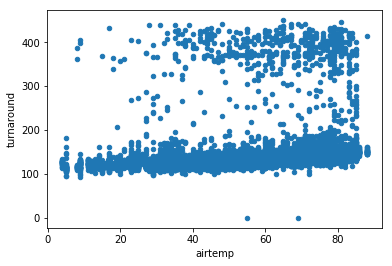

In [35]:
df = pd.read_sql_query('''
WITH weather_avg AS (
    SELECT
            "DATE",
            AVG(TAVG) as airtemp
        FROM weather
        GROUP BY "DATE"
)
SELECT
        airtemp,
        turnaround
    FROM roast
        INNER JOIN weather_avg USING ("DATE")
''', con)
df.plot.scatter(x='airtemp', y='turnaround')

Hmm, that seems odd. A big swath of outliers for turnaround temperature, probably from faulty roasts (we have plenty of those). Let's filter those out.

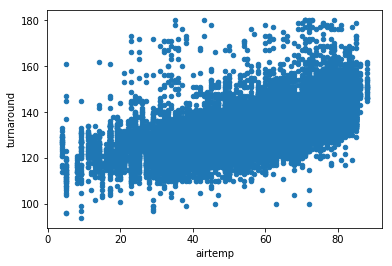

In [37]:
df = pd.read_sql_query('''
WITH weather_avg AS (
    SELECT
            "DATE",
            AVG(TAVG) as airtemp
        FROM weather
        GROUP BY "DATE"
)
SELECT
        airtemp,
        turnaround
    FROM roast
        INNER JOIN weather_avg USING ("DATE")
    WHERE turnaround BETWEEN 80 AND 180 
''', con)
df.plot.scatter(x='airtemp', y='turnaround')

In [38]:
df['airtemp'].corr(df['turnaround'])

0.651066912037672

A somewhat significant correlation.

What about the temperature delta between drop and turnaround?

-0.2874667598061063

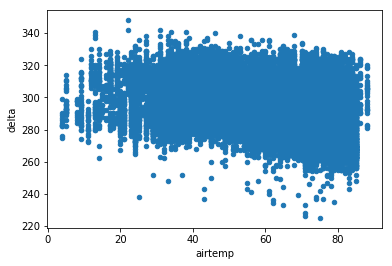

In [39]:
df = pd.read_sql_query('''
WITH weather_avg AS (
    SELECT
            "DATE",
            AVG(TAVG) as airtemp
        FROM weather
        GROUP BY "DATE"
)
SELECT
        airtemp,
        "drop" - turnaround as delta
    FROM roast
        INNER JOIN weather_avg USING ("DATE")
    WHERE turnaround BETWEEN 80 AND 180  AND "drop" > 400
''', con)
df.plot.scatter(x='airtemp', y='delta')
df['airtemp'].corr(df['delta'])

Not as strong correlation there.

## Looking ahead

My suspicions of correlation between ambient air temperature and turnaround temperature are confirmed. I plan to continue this exploration, with the hopes that I will be able to predict how roast profiles will be affected by ambient temperature, and adjust roasts to maintain profile consistency as temperature fluctuates throughout the year.

Probably some other questions I can answer with all this data, too...